In [1]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import numpy as np
from scipy.stats import beta
import pandas as pd
import pymc3 as pm

from dask.distributed import Client, LocalCluster
import dask.delayed

import logging

# Session level randomization with independent sessions

In [2]:
num_users = 10000

sessions_per_user = np.random.geometric(0.5, size=num_users)

# each user has some baseline conversion rate, we'll say ~10%
baseline_conversion_rates = np.random.beta(100, 900, size=num_users);

# treatment group will get a +2% lift in conversion (20% relative increase)
conversion_uplifts = np.random.beta(20, 980, size=num_users);

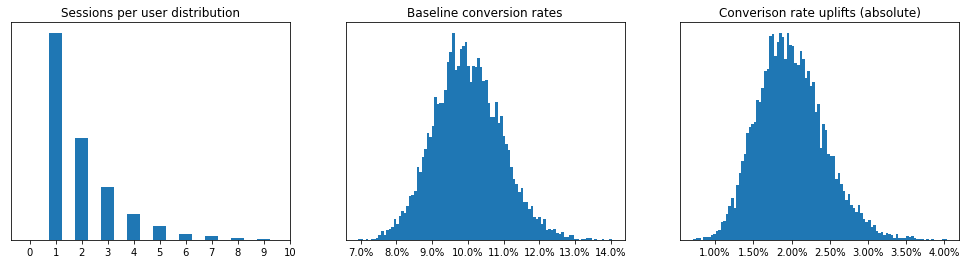

In [3]:
fig, axs = plt.subplots(1, 3, figsize=(17, 4));
axs[0].hist(sessions_per_user, bins=np.arange(0, 11)-0.5, range=(0, 11), density=True, rwidth=0.5);
axs[0].set_title('Sessions per user distribution');
axs[0].get_yaxis().set_visible(False);
axs[0].set_xticks([x for x in range(0, 11)]);
axs[0].set_xticklabels([str(x) for x in range(0, 11)]);


axs[1].hist(baseline_conversion_rates, bins=100, density=True);
axs[1].set_title('Baseline conversion rates');
axs[1].xaxis.set_major_formatter(ticker.PercentFormatter(xmax=1));
axs[1].get_yaxis().set_visible(False);


axs[2].hist(conversion_uplifts, bins=100, density=True);
axs[2].set_title('Converison rate uplifts (absolute)');
axs[2].xaxis.set_major_formatter(ticker.PercentFormatter(xmax=1));
axs[2].get_yaxis().set_visible(False);


In [4]:
data = {
    'user': [],
    'session_id': [],
    'assignment': [],
    'session_converted': []
}

# Simulate all sessions for each user
for user_id, num_sessions in enumerate(sessions_per_user):
    for session_id in range(1, num_sessions+1):
        # randomly assign session to control (0) or test (1)
        assignment = np.random.randint(0, 2)
        
        # if assigned to test, give them a conversion boost
        new_conversion_rate = baseline_conversion_rates[user_id] + assignment*conversion_uplifts[user_id]
        
        # see if the session converted
        session_converted = np.random.choice([0, 1], p=[1-new_conversion_rate, new_conversion_rate])
        
        # record the results
        data['user'].append(user_id)
        data['session_id'].append(f"{user_id}-{session_id}")
        data['assignment'].append(assignment)
        data['session_converted'].append(session_converted)

In [5]:
df = pd.DataFrame(data)
print (f"Average sessions per user: {df.shape[0] / len(df.user.unique()):0.3f}")
df

Average sessions per user: 2.020


,user,session_id,assignment,session_converted
0,0,0-1,1,0
1,0,0-2,0,0
2,0,0-3,1,0
3,1,1-1,1,0
4,2,2-1,0,1
...,...,...,...,...
20191,9998,9998-2,1,0
20192,9998,9998-3,0,0
20193,9999,9999-1,1,0
20194,9999,9999-2,0,0


In [6]:
num_samples = 50000

control_converted = df[df.assignment==0].session_converted.sum()
control_total = df[df.assignment==0].session_converted.count()
control_samples = np.random.beta(control_converted, control_total - control_converted, size=num_samples)


test_converted = df[df.assignment==1].session_converted.sum()
test_total = df[df.assignment==1].session_converted.count()
test_samples = np.random.beta(test_converted, test_total - test_converted, size=num_samples)

In [7]:
test_gt_control = (test_samples > control_samples).mean()
print(f"Test converts higher than control: {test_gt_control:0.0%} of the time")

Test converts higher than control: 100% of the time


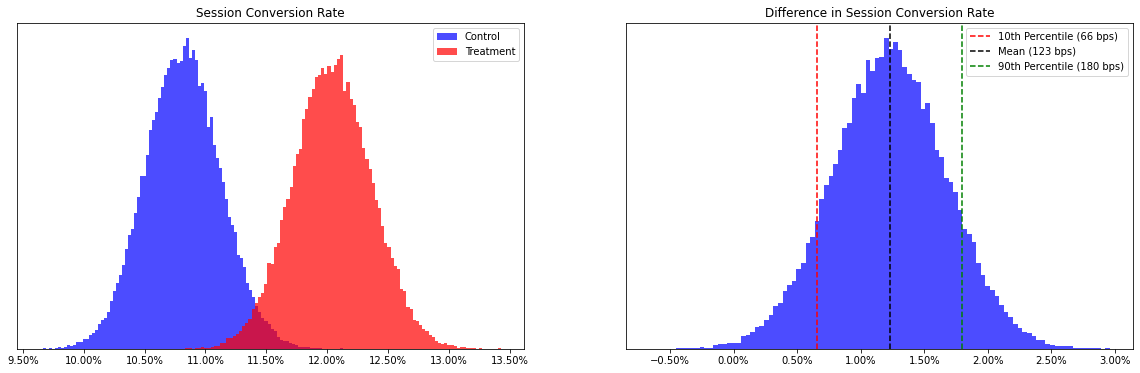

In [8]:
fig, axs = plt.subplots(1, 2, figsize=(20, 6));
axs[0].hist(control_samples, density=True, bins=100, alpha=0.7, color='b', label='Control');
axs[0].hist(test_samples, density=True, bins=100, alpha=0.7, color='r', label='Treatment');
axs[0].xaxis.set_major_formatter(ticker.PercentFormatter(xmax=1));
axs[0].set_title('Session Conversion Rate');
axs[0].get_yaxis().set_visible(False);
axs[0].legend();


diffs = test_samples - control_samples
p10_diff = np.percentile(diffs, 10)
p90_diff = np.percentile(diffs, 90)
mean_diff = np.mean(diffs)
axs[1].hist(diffs, density=True, bins=100, alpha=0.7, color='b');
axs[1].axvline(p10_diff, color='r', linestyle='dashed', label=f'10th Percentile ({p10_diff*100*100:0.0f} bps)');
axs[1].axvline(mean_diff, color='k', linestyle='dashed', label=f'Mean ({mean_diff*100*100:0.0f} bps)');
axs[1].axvline(p90_diff, color='g', linestyle='dashed', label=f'90th Percentile ({p90_diff*100*100:0.0f} bps)');
axs[1].xaxis.set_major_formatter(ticker.PercentFormatter(xmax=1));
axs[1].set_title('Difference in Session Conversion Rate');
axs[1].get_yaxis().set_visible(False);
axs[1].legend();

# Adjusting for nonindependence

In [9]:
data = {
    'user': [],
    'session_id': [],
    'assignment': [],
    'session_converted': []
}

# create a copy of the session conversion rates for each user
# we'll use this to keep track of each user's session conversion rate
# throughout the simulation in case it changes
conversion_rates = baseline_conversion_rates.copy()

# Simulate all sessions for each user
for user_id, num_sessions in enumerate(sessions_per_user):
    for session_id in range(1, num_sessions+1):
        # randomly assign session to control (0) or test (1)
        assignment = np.random.randint(0, 2)
        
        if assignment == 1:
            # increase user's conversion rate permanently
            conversion_rates[user_id] = baseline_conversion_rates[user_id] + conversion_uplifts[user_id]
            new_conversion_rate = conversion_rates[user_id]
        else:
            new_conversion_rate = conversion_rates[user_id]
        
        # see if the session converted
        session_converted = np.random.choice([0, 1], p=[1-new_conversion_rate, new_conversion_rate])
        
        # record the results
        data['user'].append(user_id)
        data['session_id'].append(f"{user_id}-{session_id}")
        data['assignment'].append(assignment)
        data['session_converted'].append(session_converted)
        
df = pd.DataFrame(data)

# Local Dask Cluster

In [10]:
cluster = LocalCluster(
    n_workers=12, 
    threads_per_worker=1, 
    processes=True, 
    silence_logs=logging.ERROR
)
client = Client(cluster) # tcp://127.0.0.1:59867
client

# client.shutdown()
# client.close()

Client Scheduler: tcp://127.0.0.1:59867 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 12 Cores: 12 Memory: 34.36 GB


# Run Simulation Function

In [28]:
def calculate_metrics(data, metric):

    df = pd.DataFrame(data)
    num_samples = 50000
    
    if metric == 'user':
        df = df.groupby(['user', 'assignment']).agg(converted=('session_converted', 'max')).reset_index()
    elif metric == 'session':
        df['converted'] = df['session_converted']
    else:
        raise NotImplementedError("Metric must be 'user' or 'session'")    

    control_converted = df[df.assignment==0].converted.sum()
    control_total = df[df.assignment==0].converted.count()
    control_samples = np.random.beta(control_converted, control_total - control_converted, size=num_samples)

    test_converted = df[df.assignment==1].converted.sum()
    test_total = df[df.assignment==1].converted.count()
    test_samples = np.random.beta(test_converted, test_total - test_converted, size=num_samples)

    # how often does test convert higher than the control?
    test_gt_control = (test_samples > control_samples).mean()
    # in what range do we think the true conversion rates lie?
    test_interval = [np.percentile(test_samples, 10), np.percentile(test_samples, 90)]
    control_interval = [np.percentile(control_samples, 10), np.percentile(control_samples, 90)]
    
    # how much better is test than control?
    diffs = test_samples - control_samples
    diff_interval = [np.percentile(diffs, 10), np.percentile(diffs, 90)]
    mean_diff = np.mean(diffs)
    
    return {
        'test_gt_control': test_gt_control,
        'test_interval': test_interval,
        'control_interval': control_interval,
        'diff_interval': diff_interval,
        'mean_diff': mean_diff
        
    }
        
def run_simulation(
        num_users=30000, 
        baseline_conversion=0.1, 
        relative_uplift=0.1, 
        is_aa_test=False,
        randomization_unit='session',
        persist_treatment_effect=False,
        geometric_p=0.5,
        conversion_dependent_on_spu=False,
        conversion_spu_func=None
    ):

    if randomization_unit not in ['session', 'user']:
        raise NotImplementedError("randomization_unit must be 'session' or 'user'")
    
    # sessions per user
    sessions_per_user = np.random.geometric(geometric_p, size=num_users)
    
    # each user has some baseline conversion rate
    if conversion_dependent_on_spu:
        _baseline_conversion_rates = conversion_spu_func(baseline_conversion, sessions_per_user)
        a = _baseline_conversion_rates*1000
        b = 1000 - _baseline_conversion_rates*1000
        baseline_conversion_rates = np.random.beta(a, b, size=num_users)
    else:
        a = baseline_conversion*1000
        b = 1000 - a
        baseline_conversion_rates = np.random.beta(a, b, size=num_users)

    if is_aa_test:
        conversion_uplifts = np.zeros(shape=num_users)
    else:
        # each user will experience a conversion uplift of 10% relative, so 0.2% or 20bps (absolute)
        # larger sample size to emphasize confidence in 20 bps effect size for the sake of demonstration
        a = baseline_conversion*relative_uplift*10000
        b = 10000 - a
        conversion_uplifts = np.random.beta(a, b, size=num_users)

    # session level randomization
    data = {
        'user': [],
        'session_id': [],
        'assignment': [],
        'session_converted': []
    }

    conversion_rates = baseline_conversion_rates.copy()

    for user_id, num_sessions in enumerate(sessions_per_user):
        if randomization_unit == 'user':
            assignment = np.random.randint(0, 2)
            
        for session_id in range(1, num_sessions+1):
            if randomization_unit == 'session':
                assignment = np.random.randint(0, 2)
            
            if assignment == 1 and persist_treatment_effect:
                # increase user conversion rate permanently
                conversion_rates[user_id] = baseline_conversion_rates[user_id] + conversion_uplifts[user_id]
                user_conversion_rate = conversion_rates[user_id]
            elif assignment == 1:
                # temporarily increase conversion rate for given session
                user_conversion_rate = baseline_conversion_rates[user_id] + conversion_uplifts[user_id]
            else:
                user_conversion_rate = conversion_rates[user_id]
            
            session_converted = np.random.choice([0, 1], p=[1-user_conversion_rate, user_conversion_rate])
            data['user'].append(user_id)
            data['session_id'].append(f"{user_id}-{session_id}")
            data['assignment'].append(assignment)
            data['session_converted'].append(session_converted)

    # now do bayesian analysis with our observered results
    return {
        'session_conversion': calculate_metrics(data, metric='session'),
        'user_conversion': calculate_metrics(data, metric='user'),
    }

In [30]:
run_simulation(
    num_users=30000, 
    baseline_conversion=0.1, 
    relative_uplift=0.1, 
    is_aa_test=False,
    randomization_unit='user',
    persist_treatment_effect=False,
    geometric_p=0.5,
    conversion_dependent_on_spu=True,
    conversion_spu_func=lambda x,y: x*2/3 + x*1/3*np.exp(-0.4*y)
)

{'session_conversion': {'test_gt_control': 1.0,
  'test_interval': [0.0902155555788382, 0.09449700302468118],
  'control_interval': [0.07602173045769126, 0.08000847063171752],
  'diff_interval': [0.011415089259289742, 0.017256651469247014],
  'mean_diff': 0.014338944066677486},
 'user_conversion': {'test_gt_control': 1.0,
  'test_interval': [0.16726041753239856, 0.17516143925513078],
  'control_interval': [0.14204752243190533, 0.1494356955346826],
  'diff_interval': [0.020084265895938532, 0.030893171551643225],
  'mean_diff': 0.025462020520587183}}

# Simulations

## A/B Test - Session Level Randomization

In [93]:
delayed_results = []

NUM_EXPERIMENTS = 250
for iteration in range(0, NUM_EXPERIMENTS):
    result = dask.delayed(run_simulation)(
        num_users=10000, 
        baseline_conversion=0.1, 
        relative_uplift=0.2, 
        is_aa_test=False,
        randomization_unit='session',
        persist_treatment_effect=False,
        geometric_p=0.5,
    )
    delayed_results.append(result)

results = dask.compute(*delayed_results)

num_positive_effects_detected = np.sum([res['session_conversion']['test_gt_control'] > 0.95 for res in results])
avg_effect_size = np.mean([res['session_conversion']['mean_diff'] for res in results if res['session_conversion']['test_gt_control'] > 0.95])

print(
    f"Detected positive effect {num_positive_effects_detected/len(results):0.1%} of the time\n"
    f"Average effect size detected: {avg_effect_size*100*100:0.0f} bps\n"
)

Detected positive effect 100.0% of the time
Average effect size detected: 201 bps



## A/B Test - Session Level Randomization with Effect Persistence

In [82]:
delayed_results = []

NUM_EXPERIMENTS = 250
for iteration in range(0, NUM_EXPERIMENTS):
    result = dask.delayed(run_simulation)(
        num_users=10000, 
        baseline_conversion=0.1, 
        relative_uplift=0.2, 
        is_aa_test=False,
        randomization_unit='session',
        persist_treatment_effect=True,
        geometric_p=0.5,
    )
    delayed_results.append(result)

results = dask.compute(*delayed_results)

num_positive_effects_detected = np.sum([res['session_conversion']['test_gt_control'] > 0.95 for res in results])
avg_effect_size = np.mean([res['session_conversion']['mean_diff'] for res in results if res['session_conversion']['test_gt_control'] > 0.95])

print(
    f"Detected positive effect {num_positive_effects_detected/len(results):0.1%} of the time\n"
    f"Average effect size detected: {avg_effect_size*100*100:0.0f} bps\n"
)

Detected positive effect 90.0% of the time
Average effect size detected: 137 bps



## A/B Test - User Level Randomization with Effect Persistence

In [83]:
delayed_results = []

NUM_EXPERIMENTS = 250
for iteration in range(0, NUM_EXPERIMENTS):
    result = dask.delayed(run_simulation)(
        num_users=10000, 
        baseline_conversion=0.1, 
        relative_uplift=0.2, 
        is_aa_test=False,
        randomization_unit='user',
        persist_treatment_effect=True,
        geometric_p=0.5,
    )
    delayed_results.append(result)

results = dask.compute(*delayed_results)

num_positive_effects_detected = np.sum([res['session_conversion']['test_gt_control'] > 0.95 for res in results])
avg_effect_size = np.mean([res['session_conversion']['mean_diff'] for res in results if res['session_conversion']['test_gt_control'] > 0.95])

print(
    f"Detected positive effect {num_positive_effects_detected/len(results):0.1%} of the time\n"
    f"Average effect size detected: {avg_effect_size*100*100:0.0f} bps\n"
)

Detected positive effect 100.0% of the time
Average effect size detected: 199 bps



# [WIP] A/A Tests: session conversion vs. user conversion when conversion & sessions per user are dependent

## User level randomization - session conversion metric

In [1]:
delayed_results = []

NUM_EXPERIMENTS = 500
for iteration in range(0, NUM_EXPERIMENTS):
    result = dask.delayed(run_simulation)(
        num_users=4000, 
        baseline_conversion=0.1, 
        relative_uplift=0.2, 
        is_aa_test=True,
        randomization_unit='user',
        persist_treatment_effect=True,
        geometric_p=0.5,
        conversion_dependent_on_spu=True,
        # TODO: add in func
    )
    delayed_results.append(result)

results = dask.compute(*delayed_results)

num_positive_effects_detected = np.sum([res['session_conversion']['test_gt_control'] > 0.95 for res in results])
avg_effect_size = np.mean([res['session_conversion']['mean_diff'] for res in results if res['session_conversion']['test_gt_control'] > 0.95])

print(
    f"Detected positive effect {num_positive_effects_detected/len(results):0.1%} of the time\n"
)

## User level randomization - user conversion metric

In [2]:
delayed_results = []

NUM_EXPERIMENTS = 500
for iteration in range(0, NUM_EXPERIMENTS):
    result = dask.delayed(run_simulation)(
        num_users=4000, 
        baseline_conversion=0.1, 
        relative_uplift=0.2, 
        is_aa_test=True,
        randomization_unit='user',
        persist_treatment_effect=True,
        geometric_p=0.5,
        conversion_dependent_on_spu=True,
        # TODO: add in func
    )
    delayed_results.append(result)

results = dask.compute(*delayed_results)

In [3]:
for sl in np.arange(0.8, 1, 0.05):
    num_positive_effects_detected = np.sum([res['user_conversion']['test_gt_control'] > sl for res in results])

    print(
        f"Significance level: {sl:0.0%} - "
        f"detected positive effect {num_positive_effects_detected/len(results):0.1%} of the time\n"
    )